# Kepler Framework Emulation

In [1]:
import os
import gc
import tqdm

import numpy as np
import array
import pandas as pd
#import matplotlib.pyplot as plt
import kepler 
import ROOT
import root_numpy

import rootplotlib as rpl
import mplhep as hep
#plt.style.use(hep.style.ROOT)
ROOT.gStyle.SetOptStat(0);
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence


In [ ]:
print('End of script')

In [2]:
os.getcwd()

'/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/kepler'

In [3]:
l_path  = "../../../Jpsiee"

data_path    = '/home/pedro.lima/data'
analysis_path = ''

dpath = '/home/pedro.lima/data/data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins/data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins_et{ET}_eta{ETA}.npz'

tpath = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20220401_v8-34/ElectronRinger{OP_NAME}TriggerConfig.conf'

## Setup Ringer v1:

In [4]:
def my_generator( df ):
    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]

    from Gaugi import load
    import numpy as np
    d = load(path)

    # new df
    data_df = pd.DataFrame(data=d['data'], columns=d['features'])

    # norm considering all rings
    #all_rings = ['L2Calo_ring_%i' %iring for iring in range(100)]
    #data_df.loc[:, all_rings] = norm1(data_df[all_rings].values)

    # for new training, we selected 3/4 of rings in each layer
    #pre-sample - 8 rings
    # EM1 - 64 rings
    # EM2 - 8 rings
    # EM3 - 8 rings
    # Had1 - 4 rings
    # Had2 - 4 rings
    # Had3 - 4 rings
    prefix = 'L2Calo_ring_%i'
    #col_names= ["trig_L2_cl_ring_%d"%i for i in range(100)]

    # rings presmaple 
    presample = [prefix %iring for iring in range(3*8//4)]

    # EM1 list
    sum_rings = 8
    em1 = [prefix %iring for iring in range(sum_rings, sum_rings+(3*64//4))]

    # EM2 list
    sum_rings = 8+64
    em2 = [prefix %iring for iring in range(sum_rings, sum_rings+(3*8//4))]

    # EM3 list
    sum_rings = 8+64+8
    em3 = [prefix %iring for iring in range(sum_rings, sum_rings+(3*8//4))]

    # HAD1 list
    sum_rings = 8+64+8+8
    had1 = [prefix %iring for iring in range(sum_rings, sum_rings+(3*4//4))]

    # HAD2 list
    sum_rings = 8+64+8+8+4
    had2 = [prefix %iring for iring in range(sum_rings, sum_rings+(3*4//4))]

    # HAD3 list
    sum_rings = 8+64+8+8+4+4
    had3 = [prefix %iring for iring in range(sum_rings, sum_rings+(3*4//4))]

    selection_list = presample+em1+em2+em3+had1+had2+had3

    #data = norm1(d['data'][:,1:101])

    # normalization considering only in half of rings
    #data = norm1(data_df[selection_list].values)

    # normalization considering only a quarter of rings
    data = norm1(data_df[selection_list].values)
    return [rings]

decorators = []
for iname, iop in zip(['tight', 'medium', 'loose', 'vloose'], ['Tight', 'Medium', 'Loose', 'VeryLoose']):
    decorators.append(kepler.pandas.RingerDecorator(column='ringer_v8_34_%s' %(iname), path=tpath.format(OP_NAME=iop), generator=my_generator))

2022-04-04 13:52:59,515 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20220401_v8-34/ElectronRingerTightTriggerConfig.conf
2022-04-04 13:53:01,259 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20220401_v8-34/ElectronRingerMediumTriggerConfig.conf
2022-04-04 13:53:02,127 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20220401_v8-34/ElectronRingerLooseTriggerConfig.conf
2022-04-04 13:53:03,011 | Py.RingerDecorator                      INFO Reading... /home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20220401_v8-34/ElectronRingerVeryLooseTriggerConfig.conf


2022-04-04 13:52:59.835670: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-04 13:52:59.835719: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: UNKNOWN ERROR (-1)
2022-04-04 13:52:59.835739: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (caloba53): /proc/driver/nvidia/version does not exist
2022-04-04 13:52:59.836127: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-04 13:52:59.895838: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-04-04 13:52:59.905820: I tensorflow/compiler/xla/service/service.c

## Setup Chains:

In [5]:
# create my chain
chains = []
for iop in ['tight', 'medium', 'loose', 'vloose']:
    chains.append(kepler.pandas.menu.ElectronSequence( "HLT_e5_lh%s_nod0_ringer_v8_34" %(iop), 
                                                        L1Seed = 'L1_EM3', 
                                                        l2calo_column = 'ringer_v8_34_%s' %(iop) )
                 )
    chains.append(kepler.pandas.menu.ElectronSequence( "HLT_e5_lh%s_nod0_noringer" %(iop), 
                                                        L1Seed = 'L1_EM3')
                 )

print(chains)

OrderedDict([('L1Seed', 'L1_EM3'),
             ('L2Calo', (2000.0, 'ringer_v8_34_tight')),
             ('L2', 'trig_L2_el_cut_pt0to15'),
             ('EFCalo', 5000.0),
             ('HLT', (5000.0, 'trig_EF_el_lhtight'))])
OrderedDict([('L1Seed', 'L1_EM3'),
             ('L2Calo', (2000.0, 'trig_L2_cl_lhtight_et0to12')),
             ('L2', 'trig_L2_el_cut_pt0to15'),
             ('EFCalo', 5000.0),
             ('HLT', (5000.0, 'trig_EF_el_lhtight'))])
OrderedDict([('L1Seed', 'L1_EM3'),
             ('L2Calo', (2000.0, 'ringer_v8_34_medium')),
             ('L2', 'trig_L2_el_cut_pt0to15'),
             ('EFCalo', 5000.0),
             ('HLT', (5000.0, 'trig_EF_el_lhmedium'))])
OrderedDict([('L1Seed', 'L1_EM3'),
             ('L2Calo', (2000.0, 'trig_L2_cl_lhmedium_et0to12')),
             ('L2', 'trig_L2_el_cut_pt0to15'),
             ('EFCalo', 5000.0),
             ('HLT', (5000.0, 'trig_EF_el_lhmedium'))])
OrderedDict([('L1Seed', 'L1_EM3'),
             ('L2Calo', (2000.0, 'rin

## Read all bins:

In [6]:
drop_columns = [
        'RunNumber', 
        'trig_L2_cl_e2tsts1',
        'trig_L2_el_hastrack', 
        'trig_L2_el_pt', 
        'trig_L2_el_eta',
        'trig_L2_el_phi', 
        'trig_L2_el_caloEta', 
        'trig_L2_el_trkClusDeta',
        'trig_L2_el_trkClusDphi', 
        'trig_L2_el_etOverPt', 
        'trig_EF_cl_et',
        'trig_EF_el_et', 
        'trig_EF_el_lhtight', 
        'trig_EF_el_lhmedium',
        'trig_EF_el_lhloose', 
        'trig_EF_el_lhvloose', 
        'el_etaBE2', 
        'L1_EM3', 
        'L1_EM7', 
        'L1_EM15VH', 
        'L1_EM15VHI',
        'L1_EM20VH',
        'L1_EM20VHI', 
        'L1_EM22VH', 
        'L1_EM22VHI', 
        'L1_EM24VHI',
        'trig_L2_cl_lhvloose_et0to12', 
        'trig_L2_cl_lhvloose_et12to20',
        'trig_L2_cl_lhvloose_et22toInf', 
        'trig_L2_cl_lhloose_et0to12',
        'trig_L2_cl_lhloose_et12to20', 
        'trig_L2_cl_lhloose_et22toInf',
        'trig_L2_cl_lhmedium_et0to12', 
        'trig_L2_cl_lhmedium_et12to20',
        'trig_L2_cl_lhmedium_et22toInf', 
        'trig_L2_cl_lhtight_et0to12',
        'trig_L2_cl_lhtight_et12to20', 
        'trig_L2_cl_lhtight_et22toInf',
        'trig_L2_el_cut_pt0to15', 
        'trig_L2_el_cut_pt15to20',
        'trig_L2_el_cut_pt20to50', 
        'trig_L2_el_cut_pt50toInf', 
        ]

In [7]:
def read_all_files( path , data_period, decorators, chains = [], drop_other_columns=None, drop_rings=True):
    import tqdm
    import itertools
    df_list = []
    drop_other_columns += ["trig_L2_cl_ring_%d"%i for i in range(100)] 
    for iet, ieta in tqdm.tqdm(list(itertools.product(range(3), range(5)))):    
        df_temp = kepler.load( path.format(DATA_PERIOD=data_period, ET=iet, ETA=ieta ) )
        df_temp.insert(loc=1, column='et_bin', value=iet)
        df_temp.insert(loc=2, column='eta_bin', value=ieta)
        df_temp.insert(loc=0, column='data_period', value=data_period)
        # propagate ringer
        for dec in tqdm.tqdm(decorators):
            # Apply v1 column
            dec.apply( df_temp, batch_size=2048 )
                
            # emulate chains
        for chain in tqdm.tqdm(chains):
            chain.apply(df_temp)
        if drop_other_columns:
            df_temp.drop( drop_other_columns, axis=1, inplace=True )
        df_list.append(df_temp)
            
    return pd.concat(df_list)

df_all = []
for iperiod in ['data17', 'data18']:# 
    df_all.append(read_all_files(dpath, data_period=iperiod, decorators=decorators, chains=chains, drop_other_columns=drop_columns))
m_df = pd.concat(df_all)#read_all_files(dpath, decorators=decorators, chains=chains)#, drop_other_columns=drop_columns, drop_rings=True)    
gc.collect()

  0%|          | 0/15 [00:09<?, ?it/s]


NameError: name 'path' is not defined

In [ ]:
del decorators, chains
gc.collect()

In [ ]:
m_df.head()

In [10]:
m_df.data_period.unique()

array(['data17', 'data18'], dtype=object)

In [11]:
def hist1d( name, values, bins, density=False ):
    counts, dummy = np.histogram(values, bins=bins, density=density )
    hist = ROOT.TH1F( name, '', len(bins)-1, array.array('d',bins))
    root_numpy.array2hist(counts, hist)
    return hist

def add_legend(x, y, legends):
    rpl.add_legend( legends, x, y, x+0.98, y+0.20, textsize=12, option='p' )

In [12]:
markers = [22, 26, 23, 32]
colors  = [ROOT.kBlue-4, ROOT.kBlack, ROOT.kGreen-4, ROOT.kGray]

In [13]:
plot_path = os.path.join(analysis_path, 'plots/emulation')
# create a folder to save all figures if do not exist
os.makedirs(plot_path, exist_ok=True)

# Measure the signal efficiency in `HLT_e5_lh(ALL)_nod0`

## Efficiency with respect to $E_T$

In [14]:
def make_et_plot(dataframe, chain, chain_step, l2suffix, fake=False):
    from Gaugi.constants import GeV
    # plot in eta need sum 1 in chain threshold 

    m_bins = np.arange(3, 16, step=.5).tolist()
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
    
    step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    # cuts for all
    total   = aux_df
    passed  = aux_df.loc[(aux_df['%s_%s' %(step_decision, l2suffix)] == 1)]
    
    h_num = hist1d('et_num', passed['el_et']/GeV, m_bins )
    h_den = hist1d('et_den', total['el_et']/GeV, m_bins )
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

### Create efficiency plots for $E_T$ in HLT step

100%|██████████| 4/4 [00:11<00:00,  2.82s/it]
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/eff_et_HLT_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/eff_et_HLT_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/eff_et_HLT_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/eff_et_HLT_e5_lhvloose_root.pdf has been created


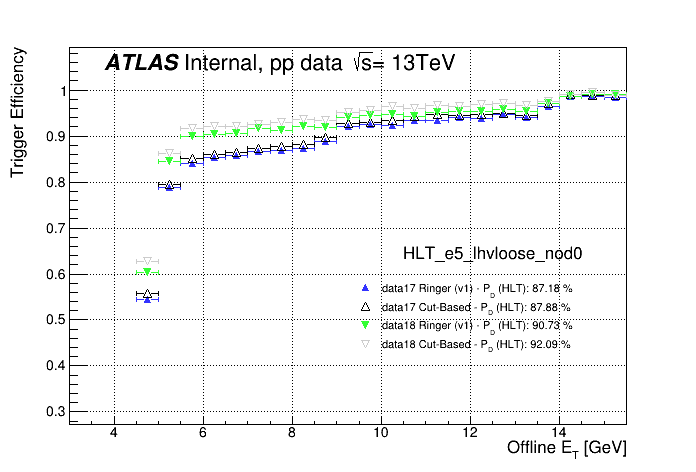

In [15]:
step = 'HLT'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_et_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2017
        make_et_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    ),
        # ringer 2018
        make_et_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2018
        make_et_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], 'Offline E_{T} [GeV]', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
    add_legend( 0.5,0.25, labels)
    rpl.add_text( 0.58, 0.45, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=.5, ymaxf=1.1) 
    fig.show()
    fig.savefig(plot_path+'/%s/eff_et_%s_e5_lh%s_root.pdf' %(chain, step, iop))

### Create efficiency plots for $E_T$ in FastCalo step

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/eff_et_L2Calo_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/eff_et_L2Calo_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/eff_et_L2Calo_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/eff_et_L2Calo_e5_lhvloose_root.pdf has been created


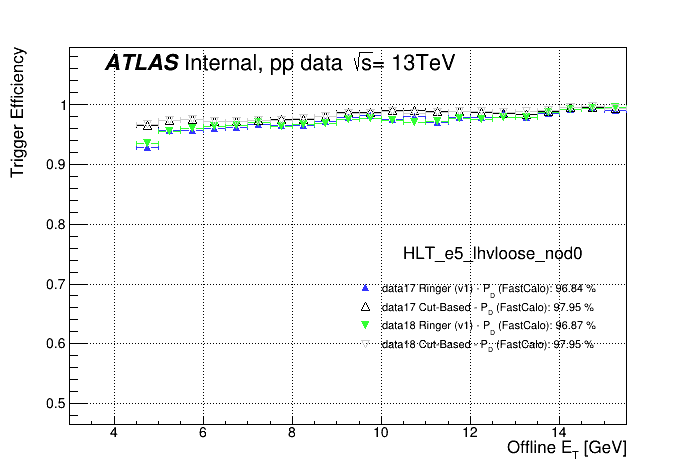

In [16]:
step = 'L2Calo'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_et_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2017
        make_et_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    ),
        # ringer 2018
        make_et_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2018
        make_et_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], 'Offline E_{T} [GeV]', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, 'FastCalo', m_info[idx, 1]*100))
    add_legend( 0.5,0.25, labels)
    rpl.add_text( 0.58, 0.45, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=.5, ymaxf=1.1) 
    fig.show()
    fig.savefig(plot_path+'/%s/eff_et_%s_e5_lh%s_root.pdf' %(chain, step, iop))

## Efficiency with respect to $\eta$

In [17]:
def make_eta_plot(dataframe, chain, chain_step, l2suffix, fake=False):
    from Gaugi.constants import GeV
    # plot in eta need sum 1 in chain threshold 

    m_bins = [-2.47,-2.37,-2.01,-1.81,-1.52,-1.37,-1.15,-0.80,-0.60,-0.10,0.00,
              0.10, 0.60, 0.80, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37, 2.47]
    
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
    
    step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    # cuts for all
    total   = aux_df.loc[(aux_df.el_et > (et_cut+1)*GeV)]
    passed  = aux_df.loc[(aux_df.el_et > (et_cut+1)*GeV) &\
                         (aux_df['%s_%s' %(step_decision, l2suffix)] == 1)]
    
    h_num = hist1d('eta_num', passed['el_eta'], m_bins )
    h_den = hist1d('eta_den', total['el_eta'], m_bins )
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

### Create efficiency plots for $\eta$ in HLT step

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/eff_eta_HLT_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/eff_eta_HLT_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/eff_eta_HLT_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/eff_eta_HLT_e5_lhvloose_root.pdf has been created


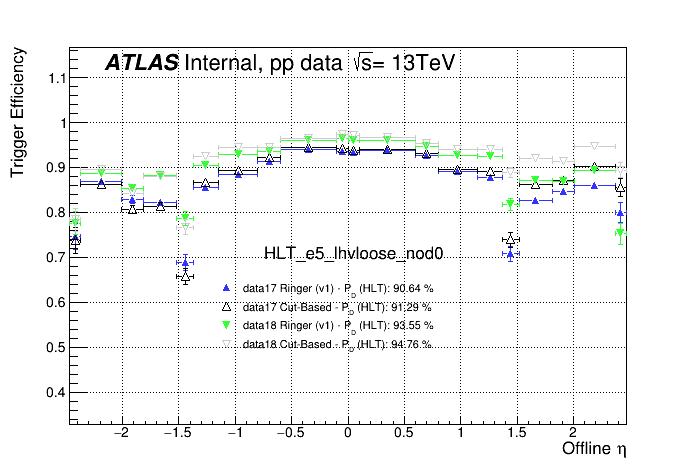

In [18]:
step = 'HLT'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_eta_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2017
        make_eta_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    ),
        # ringer 2018
        make_eta_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2018
        make_eta_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], 'Offline #eta', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
    add_legend( 0.3,0.25, labels)
    rpl.add_text( 0.38, 0.45, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True, yminf=.5, ymaxf=1.2) 
    fig.show()
    fig.savefig(plot_path+'/%s/eff_eta_%s_e5_lh%s_root.pdf' %(chain, step, iop))

### Create efficiency plots for $\eta$ in FastCalo step

100%|██████████| 4/4 [00:10<00:00,  2.61s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/eff_eta_L2Calo_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/eff_eta_L2Calo_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/eff_eta_L2Calo_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/eff_eta_L2Calo_e5_lhvloose_root.pdf has been created


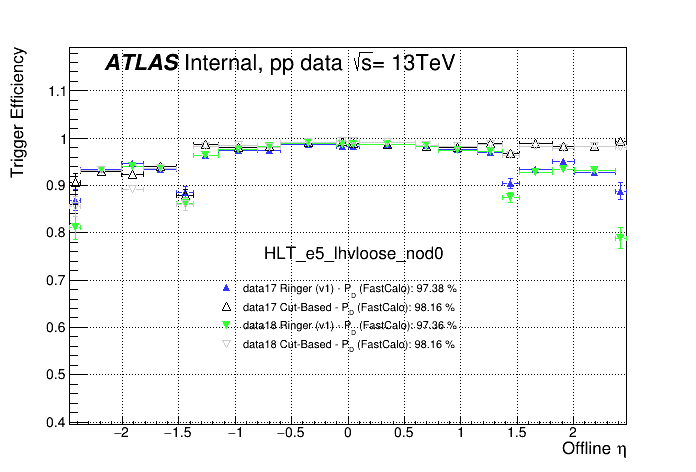

In [19]:
step = 'L2Calo'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_eta_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2017
        make_eta_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    ),
        # ringer 2018
        make_eta_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2018
        make_eta_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], 'Offline #eta', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, 'FastCalo', m_info[idx, 1]*100))
    add_legend( 0.3,0.25, labels)
    rpl.add_text( 0.38, 0.45, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True, yminf=.5, ymaxf=1.2) 
    fig.show()
    fig.savefig(plot_path+'/%s/eff_eta_%s_e5_lh%s_root.pdf' %(chain, step, iop))

## Efficiency with respect to $< \mu > $

In [20]:
def make_mu_plot(dataframe, chain, chain_step, l2suffix, fake=False):
    from Gaugi.constants import GeV
    # plot in eta need sum 1 in chain threshold 

    m_bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
    
    et_cut  = int(chain.split('_')[1][1:])
    if fake:
        #aux_df = dataframe.loc[(dataframe.target != 1) & (dataframe.el_lhvloose != 1) &\
        aux_df = dataframe.loc[(dataframe.target != 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
    else:
        offline = chain.split('_')[2]
        aux_df = dataframe.loc[(dataframe.target == 1) & (dataframe['el_%s' %(offline)] == 1) &\
                               (dataframe.el_et >= (et_cut - 5)*GeV) & (np.abs(dataframe.el_eta) <=2.47)]
    
    step_decision = chain_step + '_' + '_'.join(chain.split('_')[1:])
    # cuts for all
    total   = aux_df.loc[(aux_df.el_et > (et_cut+1)*GeV)]
    passed  = aux_df.loc[(aux_df.el_et > (et_cut+1)*GeV) &\
                         (aux_df['%s_%s' %(step_decision, l2suffix)] == 1)]
    
    h_num = hist1d('mu_num', passed['avgmu'], m_bins )
    h_den = hist1d('mu_den', total['avgmu'], m_bins )
    h_eff = rpl.hist1d.divide(h_num,h_den) 
    
    return h_eff, len(passed)/len(total)

### Create Efficiency plots for $< \mu >$ in HLT step

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/eff_mu_HLT_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/eff_mu_HLT_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/eff_mu_HLT_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/eff_mu_HLT_e5_lhvloose_root.pdf has been created


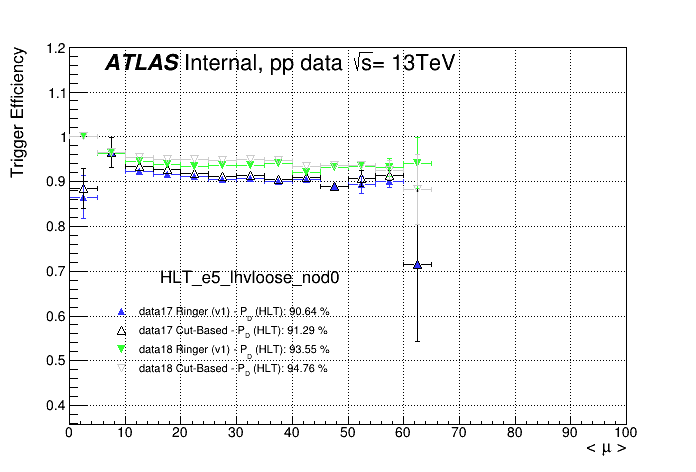

In [21]:
step = 'HLT'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_mu_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2017
        make_mu_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    ),
        # ringer 2018
        make_mu_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2018
        make_mu_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], '< #mu >', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
    add_legend( 0.15,0.2, labels)
    rpl.add_text( 0.23, 0.4, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True, yminf=.5, ymaxf=1.2) 
    fig.show()
    fig.savefig(plot_path+'/%s/eff_mu_%s_e5_lh%s_root.pdf' %(chain, step, iop))

### Create Efficiency plots for $< \mu >$ in FastCalo step

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/eff_mu_L2Calo_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/eff_mu_L2Calo_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/eff_mu_L2Calo_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/eff_mu_L2Calo_e5_lhvloose_root.pdf has been created


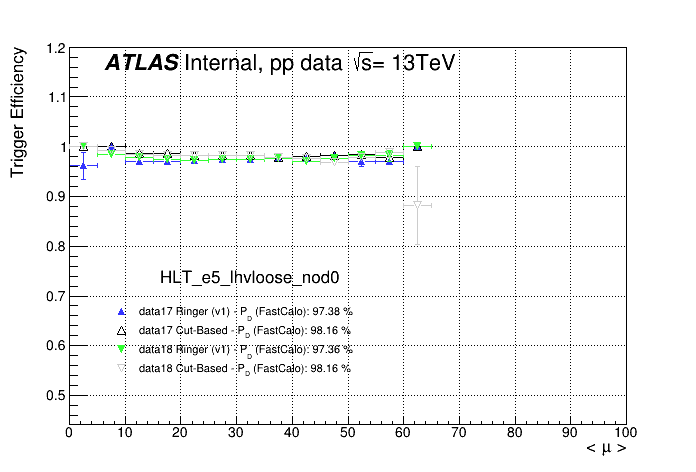

In [22]:
step = 'L2Calo'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_mu_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2017
        make_mu_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    ),
        # ringer 2018
        make_mu_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', 
                    ),
        # no ringer 2018
        make_mu_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', 
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], '< #mu >', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - P_{D} (%s): %1.2f %%' %(ilabel, 'FastCalo', m_info[idx, 1]*100))
    add_legend( 0.15,0.2, labels)
    rpl.add_text( 0.23, 0.4, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True, yminf=.5, ymaxf=1.2) 
    fig.show()
    fig.savefig(plot_path+'/%s/eff_mu_%s_e5_lh%s_root.pdf' %(chain, step, iop))

# Measure the fake rate in `HLT_e5_lh(ALL)_nod0`

## Fake rate with respect to $E_T$

### Create efficiency plots for $E_T$ in HLT step

100%|██████████| 4/4 [00:17<00:00,  4.41s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/fake_et_HLT_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/fake_et_HLT_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/fake_et_HLT_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/fake_et_HLT_e5_lhvloose_root.pdf has been created


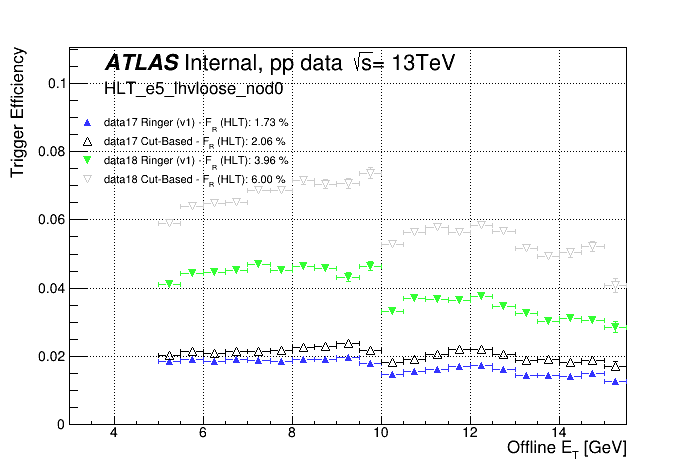

In [23]:
step = 'HLT'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_et_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True,
                    ),
        # no ringer 2017
        make_et_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True,
                    ),
        # ringer 2018
        make_et_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True,
                    ),
        # no ringer 2018
        make_et_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True,
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], 'Offline E_{T} [GeV]', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
    add_legend( 0.1,0.6, labels)
    rpl.add_text( 0.15, 0.8, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=.0, ymaxf=1.5) 
    fig.show()
    fig.savefig(plot_path+'/%s/fake_et_%s_e5_lh%s_root.pdf' %(chain, step, iop))

### Create efficiency plots for $E_T$ in FastCalo step

100%|██████████| 4/4 [00:19<00:00,  5.00s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/fake_et_L2Calo_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/fake_et_L2Calo_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/fake_et_L2Calo_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/fake_et_L2Calo_e5_lhvloose_root.pdf has been created


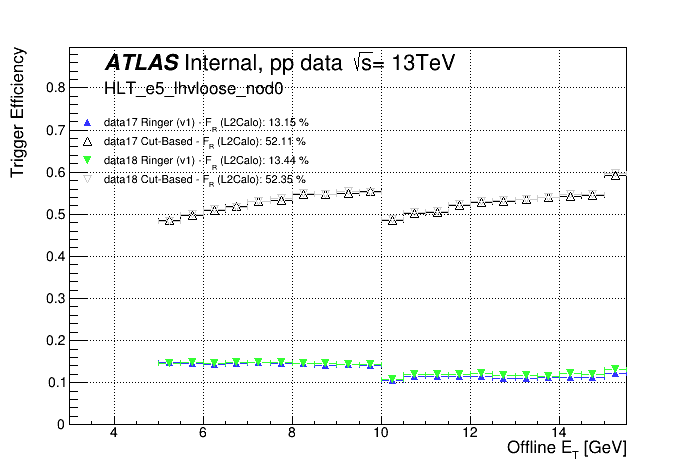

In [24]:
step = 'L2Calo'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_et_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True,
                    ),
        # no ringer 2017
        make_et_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True,
                    ),
        # ringer 2018
        make_et_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True,
                    ),
        # no ringer 2018
        make_et_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True,
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], 'Offline E_{T} [GeV]', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
    add_legend( 0.1,0.6, labels)
    rpl.add_text( 0.15, 0.8, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=.0, ymaxf=1.5)
    fig.show()
    fig.savefig(plot_path+'/%s/fake_et_%s_e5_lh%s_root.pdf' %(chain, step, iop))

## Efficiency with respect to $\eta$

### Create efficiency plots for $\eta$ in HLT step

100%|██████████| 4/4 [00:22<00:00,  5.58s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/fake_eta_HLT_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/fake_eta_HLT_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/fake_eta_HLT_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/fake_eta_HLT_e5_lhvloose_root.pdf has been created


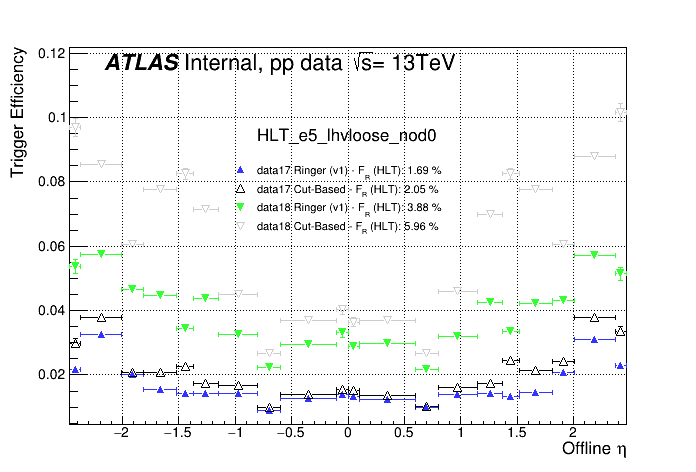

In [25]:
step = 'HLT'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_eta_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True
                    ),
        # no ringer 2017
        make_eta_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True
                    ),
        # ringer 2018
        make_eta_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True
                    ),
        # no ringer 2018
        make_eta_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], 'Offline #eta', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
    add_legend( 0.32,0.5, labels)
    rpl.add_text( 0.37, 0.7, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True, yminf=.5, ymaxf=1.2) 
    fig.show()
    fig.savefig(plot_path+'/%s/fake_eta_%s_e5_lh%s_root.pdf' %(chain, step, iop))

### Create efficiency plots for $\eta$ in FastCalo step

100%|██████████| 4/4 [00:24<00:00,  6.04s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/fake_eta_L2Calo_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/fake_eta_L2Calo_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/fake_eta_L2Calo_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/fake_eta_L2Calo_e5_lhvloose_root.pdf has been created


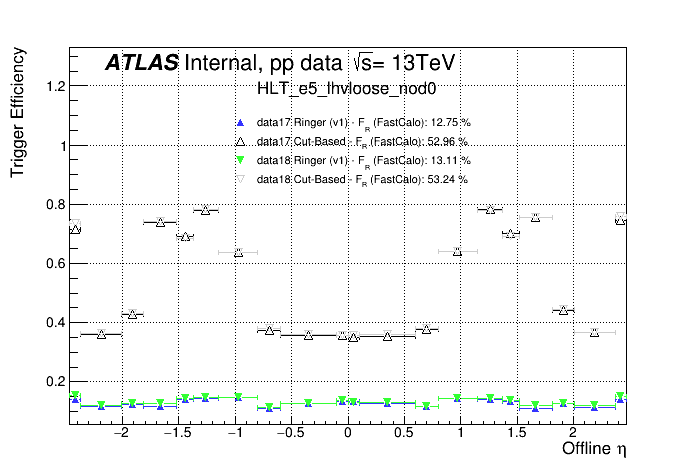

In [26]:
step = 'L2Calo'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_eta_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True
                    ),
        # no ringer 2017
        make_eta_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True
                    ),
        # ringer 2018
        make_eta_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True
                    ),
        # no ringer 2018
        make_eta_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], 'Offline #eta', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, 'FastCalo', m_info[idx, 1]*100))
    add_legend( 0.32,0.6, labels)
    rpl.add_text( 0.37, 0.8, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True, yminf=.5, ymaxf=1.7) 
    fig.show()
    fig.savefig(plot_path+'/%s/fake_eta_%s_e5_lh%s_root.pdf' %(chain, step, iop))

## Efficiency with respect to $< \mu > $

### Create Efficiency plots for $< \mu >$ in HLT step

100%|██████████| 4/4 [00:21<00:00,  5.46s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/fake_mu_HLT_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/fake_mu_HLT_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/fake_mu_HLT_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/fake_mu_HLT_e5_lhvloose_root.pdf has been created


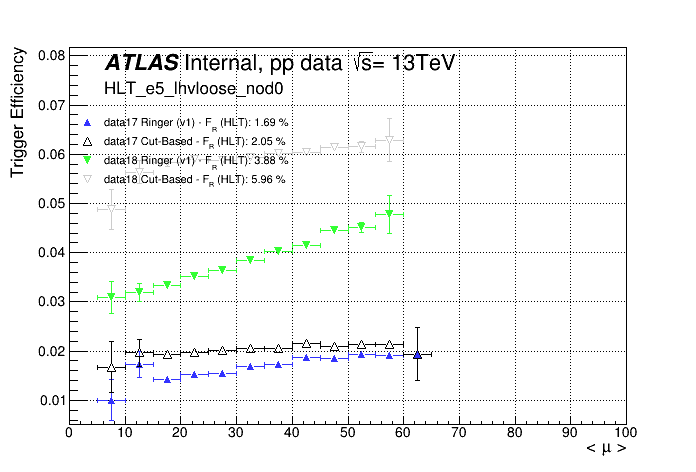

In [27]:
step = 'HLT'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_mu_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True
                    ),
        # no ringer 2017
        make_mu_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True
                    ),
        # ringer 2018
        make_mu_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True
                    ),
        # no ringer 2018
        make_mu_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], '< #mu >', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, step, m_info[idx, 1]*100))
    add_legend( 0.1,0.6, labels)
    rpl.add_text( 0.15, 0.8, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True, yminf=.5, ymaxf=1.3) 
    fig.show()
    fig.savefig(plot_path+'/%s/fake_mu_%s_e5_lh%s_root.pdf' %(chain, step, iop))

### Create Efficiency plots for $< \mu >$ in FastCalo step

100%|██████████| 4/4 [00:23<00:00,  5.88s/it]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhtight_nod0/fake_mu_L2Calo_e5_lhtight_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhmedium_nod0/fake_mu_L2Calo_e5_lhmedium_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhloose_nod0/fake_mu_L2Calo_e5_lhloose_root.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file ../../../Jpsiee/analysis/v1/r0/plots/emulation/HLT_e5_lhvloose_nod0/fake_mu_L2Calo_e5_lhvloose_root.pdf has been created


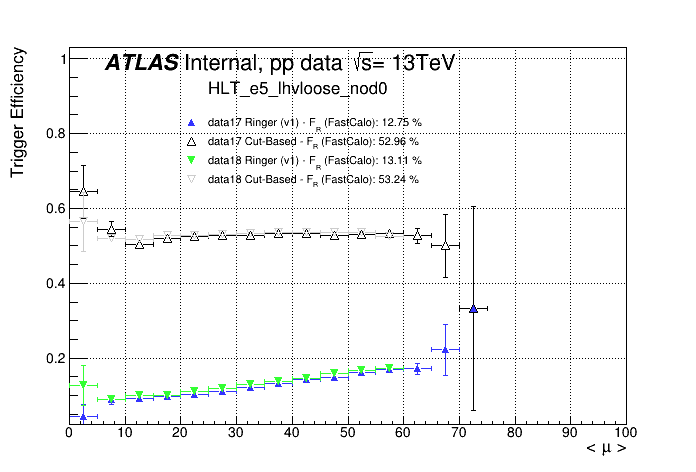

In [28]:
step = 'L2Calo'
for iop in tqdm.tqdm(['tight', 'medium', 'loose', 'vloose']):
    chain = 'HLT_e5_lh%s_nod0' %(iop)
    m_info = np.array([
        # ringer 2017
        make_mu_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True
                    ),
        # no ringer 2017
        make_mu_plot(m_df.loc[m_df.data_period == 'data17'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True
                    ),
        # ringer 2018
        make_mu_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='ringer_v1', fake=True
                    ),
        # no ringer 2018
        make_mu_plot(m_df.loc[m_df.data_period == 'data18'], 
                     chain, chain_step=step, l2suffix='noringer', fake=True
                    )
    ])
    
    # make the plot
    fig = rpl.create_canvas('my_canvas', canw=700, canh=500, grid=True)
    fig = rpl.plot_profiles( m_info[:,0], '< #mu >', colors, markers, grid=True )
    rpl.set_atlas_label(0.15,0.85,'Internal, pp data #sqrt{s}= 13TeV')
    labels = []
    for idx, ilabel in enumerate(['data17 Ringer (v1)', 'data17 Cut-Based', 'data18 Ringer (v1)', 'data18 Cut-Based']):
        labels.append('%s - F_{R} (%s): %1.2f %%' %(ilabel, 'FastCalo', m_info[idx, 1]*100))
    add_legend( 0.25,0.6, labels)
    rpl.add_text( 0.3, 0.8, 'HLT_e5_lh%s_nod0' %(iop), textsize=0.04)
    rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True, yminf=.5, ymaxf=1.6) 
    fig.show()
    fig.savefig(plot_path+'/%s/fake_mu_%s_e5_lh%s_root.pdf' %(chain, step, iop))